In [22]:
from typing import Dict, Optional, Any
import os
import pickle
import collections

import mdtraj as md
import numpy as np
import scipy.stats
import pyemma
import pandas as pd
import lovelyplots
import matplotlib.pyplot as plt
plt.style.use("ipynb")

import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams['axes.formatter.limits'] = (-10000, 10000)  # Controls range before scientific notation is used
mpl.rcParams['font.size'] = 20

import load_trajectory
import utils as analysis_utils
import pyemma_helper

from jamun import utils

### Paths

Load the results for the corresponding experiment, trajectories and reference trajectories.

In [ ]:
# results_dir = "/homefs/home/daigavaa/jamun/analysis_results"
results_dir = "/data/bucket/kleinhej/jamun-analysis/"

print(f"Results directory: {results_dir}")

In [24]:
# experiment = "Our_2AA"
# traj_name = "JAMUN"
# ref_traj_name = "JAMUNReference_2AA"

#experiment = "Our_5AA"
#traj_name = "JAMUN"
#ref_traj_name = "JAMUNReference_5AA"

experiment = "MDGen_4AA_no_clip_v2"
traj_name = "JAMUN"
ref_traj_name = "MDGenReference"

#experiment = "Timewarp_4AA"
#traj_name = "JAMUN"
#ref_traj_name = "TimewarpReference"

# experiment = "Timewarp_2AA"
# traj_name = "JAMUN"
# ref_traj_name = "TimewarpReference"

In [ ]:
# output_dir = os.path.join(results_dir, "plots", experiment, traj_name, f"ref={ref_traj_name}")
output_dir = os.path.join("/data/bucket/kleinhej/jamun-plots", experiment, traj_name, f"ref={ref_traj_name}")
os.makedirs(output_dir, exist_ok=True)

print(f"Plots will be saved to {output_dir}")

### Load All Trajectories

In [ ]:
results_path = os.path.join(
    results_dir, experiment, traj_name, f"ref={ref_traj_name}")
print(f"Searching for results in {results_path}")

In [ ]:
def load_results_path(results_path: str, is_benchmark_reference: bool) -> pd.DataFrame:
    """Loads the results as a pandas DataFrame."""
    results = []
    for results_file in sorted(os.listdir(results_path)):
        peptide, ext = os.path.splitext(results_file)
        if ext != ".pkl":
            continue

        if is_benchmark_reference:
            if peptide.endswith("_benchmark"):
                peptide = peptide[:-len("_benchmark")]
            else:
                continue

        with open(os.path.join(results_path, results_file), "rb") as f:
            all_results = pickle.load(f)

        results.append({
            "traj": traj_name,
            "ref_traj": ref_traj_name,
            "peptide": peptide,
            "results": all_results["results"],
            "args": all_results["args"],
        })
    return pd.DataFrame(results)


results_df = load_results_path(results_path, is_benchmark_reference=False)
benchmark_reference_results_df = load_results_path(results_path, is_benchmark_reference=True)

if len(benchmark_reference_results_df) > 0:
    # Join the two DataFrames based on the peptide column
    results_df = pd.merge(results_df, benchmark_reference_results_df, on=["peptide", "traj", "ref_traj"], prefixes=("", "ref_benchmark_"))
    have_benchmark_reference = True
else:
    have_benchmark_reference = False

results_df

In [ ]:
# Filter based on peptide names.
if "2AA" in experiment:
    peptides = ["AP", "MY", "VV","GR"]
    peptides = ["_".join([utils.convert_to_three_letter_code(aa) for aa in peptide]) for peptide in peptides]
    print(peptides)

    results_df = results_df[results_df["peptide"].isin(peptides)]

    sampled_results_df = results_df.copy()
    sampled_results_df = sampled_results_df.reset_index(drop=True)

elif "5AA" in experiment:
    peptides = ["KTYDI", "NRLCQ", "VWSPF"]
    peptides = ["uncapped_" + peptide for peptide in peptides]
    results_df = results_df[results_df["peptide"].isin(peptides)]
    
    sampled_results_df = results_df.copy()
    sampled_results_df = sampled_results_df.reset_index(drop=True)

else:
    # Sample 4 random peptides
    sampled_results_df = results_df.sample(n=min(len(results_df), 4), random_state=42)
    sampled_results_df = sampled_results_df.reset_index(drop=True)

sampled_results_df

### Ramachandran Plots

In [29]:
def plot_ramachandran_contour(results: Dict[str, Any], dihedral_index: int, ax: Optional[plt.Axes] = None) -> plt.Axes:
    """Plots the Ramachandran contour plot of a trajectory."""

    if ax is None:
        _, ax = plt.subplots(figsize=(10, 10))

    pmf, xedges, yedges = results["pmf"], results["xedges"], results["yedges"]
    im = ax.contourf(xedges[:-1], yedges[:-1], pmf[dihedral_index], cmap="viridis", levels=50)
    contour = ax.contour(xedges[:-1], yedges[:-1], pmf[dihedral_index], colors="white", linestyles="solid", levels=10, linewidths=0.25)

    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("$\phi$")
    ax.set_ylabel("$\psi$")

    tick_eps = 0.1
    ticks = [-np.pi + tick_eps, -np.pi / 2, 0, np.pi / 2, np.pi - tick_eps]
    tick_labels = ["$-\pi$", "$-\pi/2$", "$0$", "$\pi/2$", "$\pi$"]
    ax.set_xticks(ticks, tick_labels)
    ax.set_yticks(ticks, tick_labels)
    return ax


def format_for_plot(peptide: str) -> str:
    """Formats the peptide name for plotting."""
    if peptide.startswith("uncapped_"):
        peptide = peptide[len("uncapped_"):]
    if "_" in peptide:
        return peptide.replace("_", "-")
    return utils.convert_to_one_letter_codes(peptide)

In [ ]:
if have_benchmark_reference:
    # "internal" for psi_2 - phi_2, psi_3 - phi_3, etc.
    # "all" for psi_1 - phi_2, psi_2 - phi_3, etc.
    pmf_type = "all"

    if experiment == "Our_2AA":
        num_dihedrals = 1
    elif "2AA" in experiment:
        num_dihedrals = 0
    elif "4AA" in experiment:
        num_dihedrals = 2
    elif "5AA" in experiment:
        num_dihedrals = 3

    if pmf_type == "all":
        num_dihedrals += 1

    if num_dihedrals % 2 == 0:
        label_offset = -0.5
    else:
        label_offset = 0.5
    
    ones = np.ones(num_dihedrals)
    fig, axs = plt.subplots(len(sampled_results_df), 3 * num_dihedrals+2, figsize=(12 * num_dihedrals, 4 * len(sampled_results_df)),gridspec_kw={'width_ratios': ones+[0.1]+ones+[0.1]+ones,'hspace':0.1})

    plt.rcParams.update({'font.size': 20})
    for i, row in sampled_results_df.iterrows():
        peptide = row["peptide"]

        for j in range(num_dihedrals):
            plot_ramachandran_contour(row["results"]["PMFs"]["ref_traj"][f"pmf_{pmf_type}"], j, axs[i, j])
            plot_ramachandran_contour(row["results"]["PMFs"]["traj"][f"pmf_{pmf_type}"], j, axs[i, j + num_dihedrals+1])
            plot_ramachandran_contour(row["results_same_sampling_time"]["PMFs"]["ref_traj"][f"pmf_{pmf_type}"], j, axs[i, j + 2 * num_dihedrals+2])

        # Add labels.
        axs[0, num_dihedrals // 2].text(
            label_offset+0.5,
            1.1,
            "Reference",
            horizontalalignment="center",
            verticalalignment="center",
            transform=axs[0, num_dihedrals // 2].transAxes
        )
        axs[0, num_dihedrals // 2 + num_dihedrals+1].text(
            label_offset+0.5,
            1.1,
            "JAMUN",
            horizontalalignment="center",
            verticalalignment="center",
            transform=axs[0, num_dihedrals // 2 + num_dihedrals+1].transAxes
        )
        axs[0, num_dihedrals // 2 + 2 * num_dihedrals+2].text(
            label_offset+0.5,
            1.1,
            "Reference (Benchmark)",
            horizontalalignment="center",
            verticalalignment="center",
            transform=axs[0, num_dihedrals // 2 + 2 * num_dihedrals+2].transAxes
        )
        axs[i, -1].text(
            1.1,
            0.5,
            format_for_plot(peptide),
            rotation=90,
            verticalalignment="center",
            horizontalalignment="center",
            transform=axs[i, -1].transAxes
        )


        axs[i,num_dihedrals].axis('off')
        axs[i,2*num_dihedrals+1].axis('off')
        
        
        if i != len(axs) - 1:
            for j in range(len(axs[i])):
                axs[i,j].set_xticks([])
                axs[i,j].set_xlabel("")

        for j in range(1,len(axs[i])):
            axs[i,j].set_yticks([])
            axs[i,j].set_ylabel("")
            

    plt.subplots_adjust(hspace=0.06, wspace=0.04)
    plt.savefig(os.path.join(output_dir, "ramachandran_contours.pdf"), dpi=300)
    plt.show()

else:
    # "internal" for psi_2 - phi_2, psi_3 - phi_3, etc.
    # "all" for psi_1 - phi_2, psi_2 - phi_3, etc.
    pmf_type = "all"

    if experiment == "Our_2AA":
        num_dihedrals = 1
    elif "2AA" in experiment:
        num_dihedrals = 0
    elif "4AA" in experiment:
        num_dihedrals = 2
    elif "5AA" in experiment:
        num_dihedrals = 3

    if pmf_type == "all":
        num_dihedrals += 1

    if num_dihedrals % 2 == 0:
        label_offset = -0.5
    else:
        label_offset = 0.5

    ones = list(np.ones(num_dihedrals))
    fig, axs = plt.subplots(
        len(sampled_results_df), 2 * num_dihedrals+1,
        figsize=(8 * num_dihedrals, 4 * len(sampled_results_df)),
        gridspec_kw={
            'width_ratios': ones + [0.1] + ones,
            'hspace': 0.1
        }
    )
    for i, row in sampled_results_df.iterrows():
        peptide = row["peptide"]

        for j in range(num_dihedrals):
            plot_ramachandran_contour(row["results"]["PMFs"]["ref_traj"][f"pmf_{pmf_type}"], j, axs[i, j])
            plot_ramachandran_contour(row["results"]["PMFs"]["traj"][f"pmf_{pmf_type}"], j, axs[i, j + num_dihedrals+1])

        # Add labels.
        axs[0, num_dihedrals // 2].text(
            label_offset,
            1.1,
            "Reference",
            horizontalalignment="center",
            verticalalignment="center",
            transform=axs[0, num_dihedrals // 2].transAxes,
            fontsize=16,
        )
        axs[0, num_dihedrals // 2 + num_dihedrals].text(
            label_offset+1,
            1.1,
            "JAMUN",
            horizontalalignment="center",
            verticalalignment="center",
            transform=axs[0, num_dihedrals // 2 + num_dihedrals].transAxes,
            fontsize=16,
        )
        axs[i, -1].text(
            1.1,
            0.5,
            format_for_plot(peptide),
            rotation=90,
            verticalalignment="center",
            horizontalalignment="center",
            transform=axs[i, -1].transAxes,
        )


        axs[i,num_dihedrals].axis('off')
        
        if i!=len(axs)-1:
            for j in range(len(axs[i])):
                axs[i,j].set_xticks([])
                axs[i,j].set_xlabel("")

        for j in range(1,len(axs[i])):
            axs[i,j].set_yticks([])
            axs[i,j].set_ylabel("")
            

    plt.subplots_adjust(hspace=0.06, wspace=0.04)
    plt.savefig(os.path.join(output_dir, "ramachandran_contours.pdf"), dpi=300)
    plt.show()

#### Ramachandran Plot (Single Example)

In [ ]:
plt.rcParams.update({'font.size': 16})
# "internal" for psi_2 - phi_2, psi_3 - phi_3, etc.
# "all" for psi_1 - phi_2, psi_2 - phi_3, etc.
pmf_type = "all"

if experiment == "Our_2AA":
    num_dihedrals = 1
elif "2AA" in experiment:
    num_dihedrals = 0
elif "4AA" in experiment:
    num_dihedrals = 2
elif "5AA" in experiment:
    num_dihedrals = 3

if pmf_type == "all":
    num_dihedrals += 1

if num_dihedrals % 2 == 0:
    label_offset = -0.5
else:
    label_offset = 0.5

fig, axs = plt.subplots(2, num_dihedrals, figsize=(4 * num_dihedrals, 8 ))
peptide = next(iter(sampled_results_df["peptide"]))
for j in range(num_dihedrals):
    plot_ramachandran_contour(row["results"]["PMFs"]["ref_traj"][f"pmf_{pmf_type}"], j, axs[0, j])
    plot_ramachandran_contour(row["results"]["PMFs"]["traj"][f"pmf_{pmf_type}"], j, axs[1, j])

# Add labels.

for i in range(2):
    for j in range(1,len(axs[i])):
        axs[i,j].set_yticks([])
        axs[i,j].set_ylabel("")

for j in range(len(axs[0])):
    axs[0,j].set_xticks([])
    axs[0,j].set_xlabel("")
    
axs[0, -1].text(
    1.1,
    0.5,
    "Reference MD",
    rotation=90,
    verticalalignment="center",
    horizontalalignment="center",
    transform=axs[0, -1].transAxes,
)
axs[1, -1].text(
    1.1,
    0.5,
    "JAMUN",
    rotation=90,
    verticalalignment="center",
    horizontalalignment="center",
    transform=axs[1, -1].transAxes,
)
fig.suptitle(peptide)
plt.subplots_adjust(hspace=0.06, wspace=0.04)
plt.savefig(os.path.join(output_dir, f"ramachandran_contours_{peptide}.pdf"), dpi=300)
plt.show()

### Feature Histograms

In [ ]:
plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(nrows=len(sampled_results_df), ncols=2, figsize=(14, 4 * len(sampled_results_df)), squeeze=False)
for i, row in sampled_results_df.iterrows():
    peptide = row["peptide"]

    feats = row["results"]["featurization"]
    histograms = row["results"]["feature_histograms"]

    pyemma_helper.plot_feature_histograms(
        histograms["ref_traj"]["torsions"]["histograms"],
        histograms["ref_traj"]["torsions"]["edges"],
        feature_labels=feats["ref_traj"]["feats"]["torsions"].describe(),
        ax=axs[i, 0]
    )

    pyemma_helper.plot_feature_histograms(
        histograms["traj"]["torsions"]["histograms"],
        histograms["traj"]["torsions"]["edges"],    
        feature_labels=feats["traj"]["feats"]["torsions"].describe(),
        ax=axs[i, 1]
    )

    axs[i, -1].text(
        1.1,
        0.5,
        format_for_plot(peptide),
        rotation=90,
        verticalalignment="center",
        horizontalalignment="center",
        transform=axs[i, -1].transAxes,
    )

axs[0, 0].set_title("Reference")
axs[0, 1].set_title("JAMUN")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "feature_histograms.pdf"), dpi=300)
plt.show()

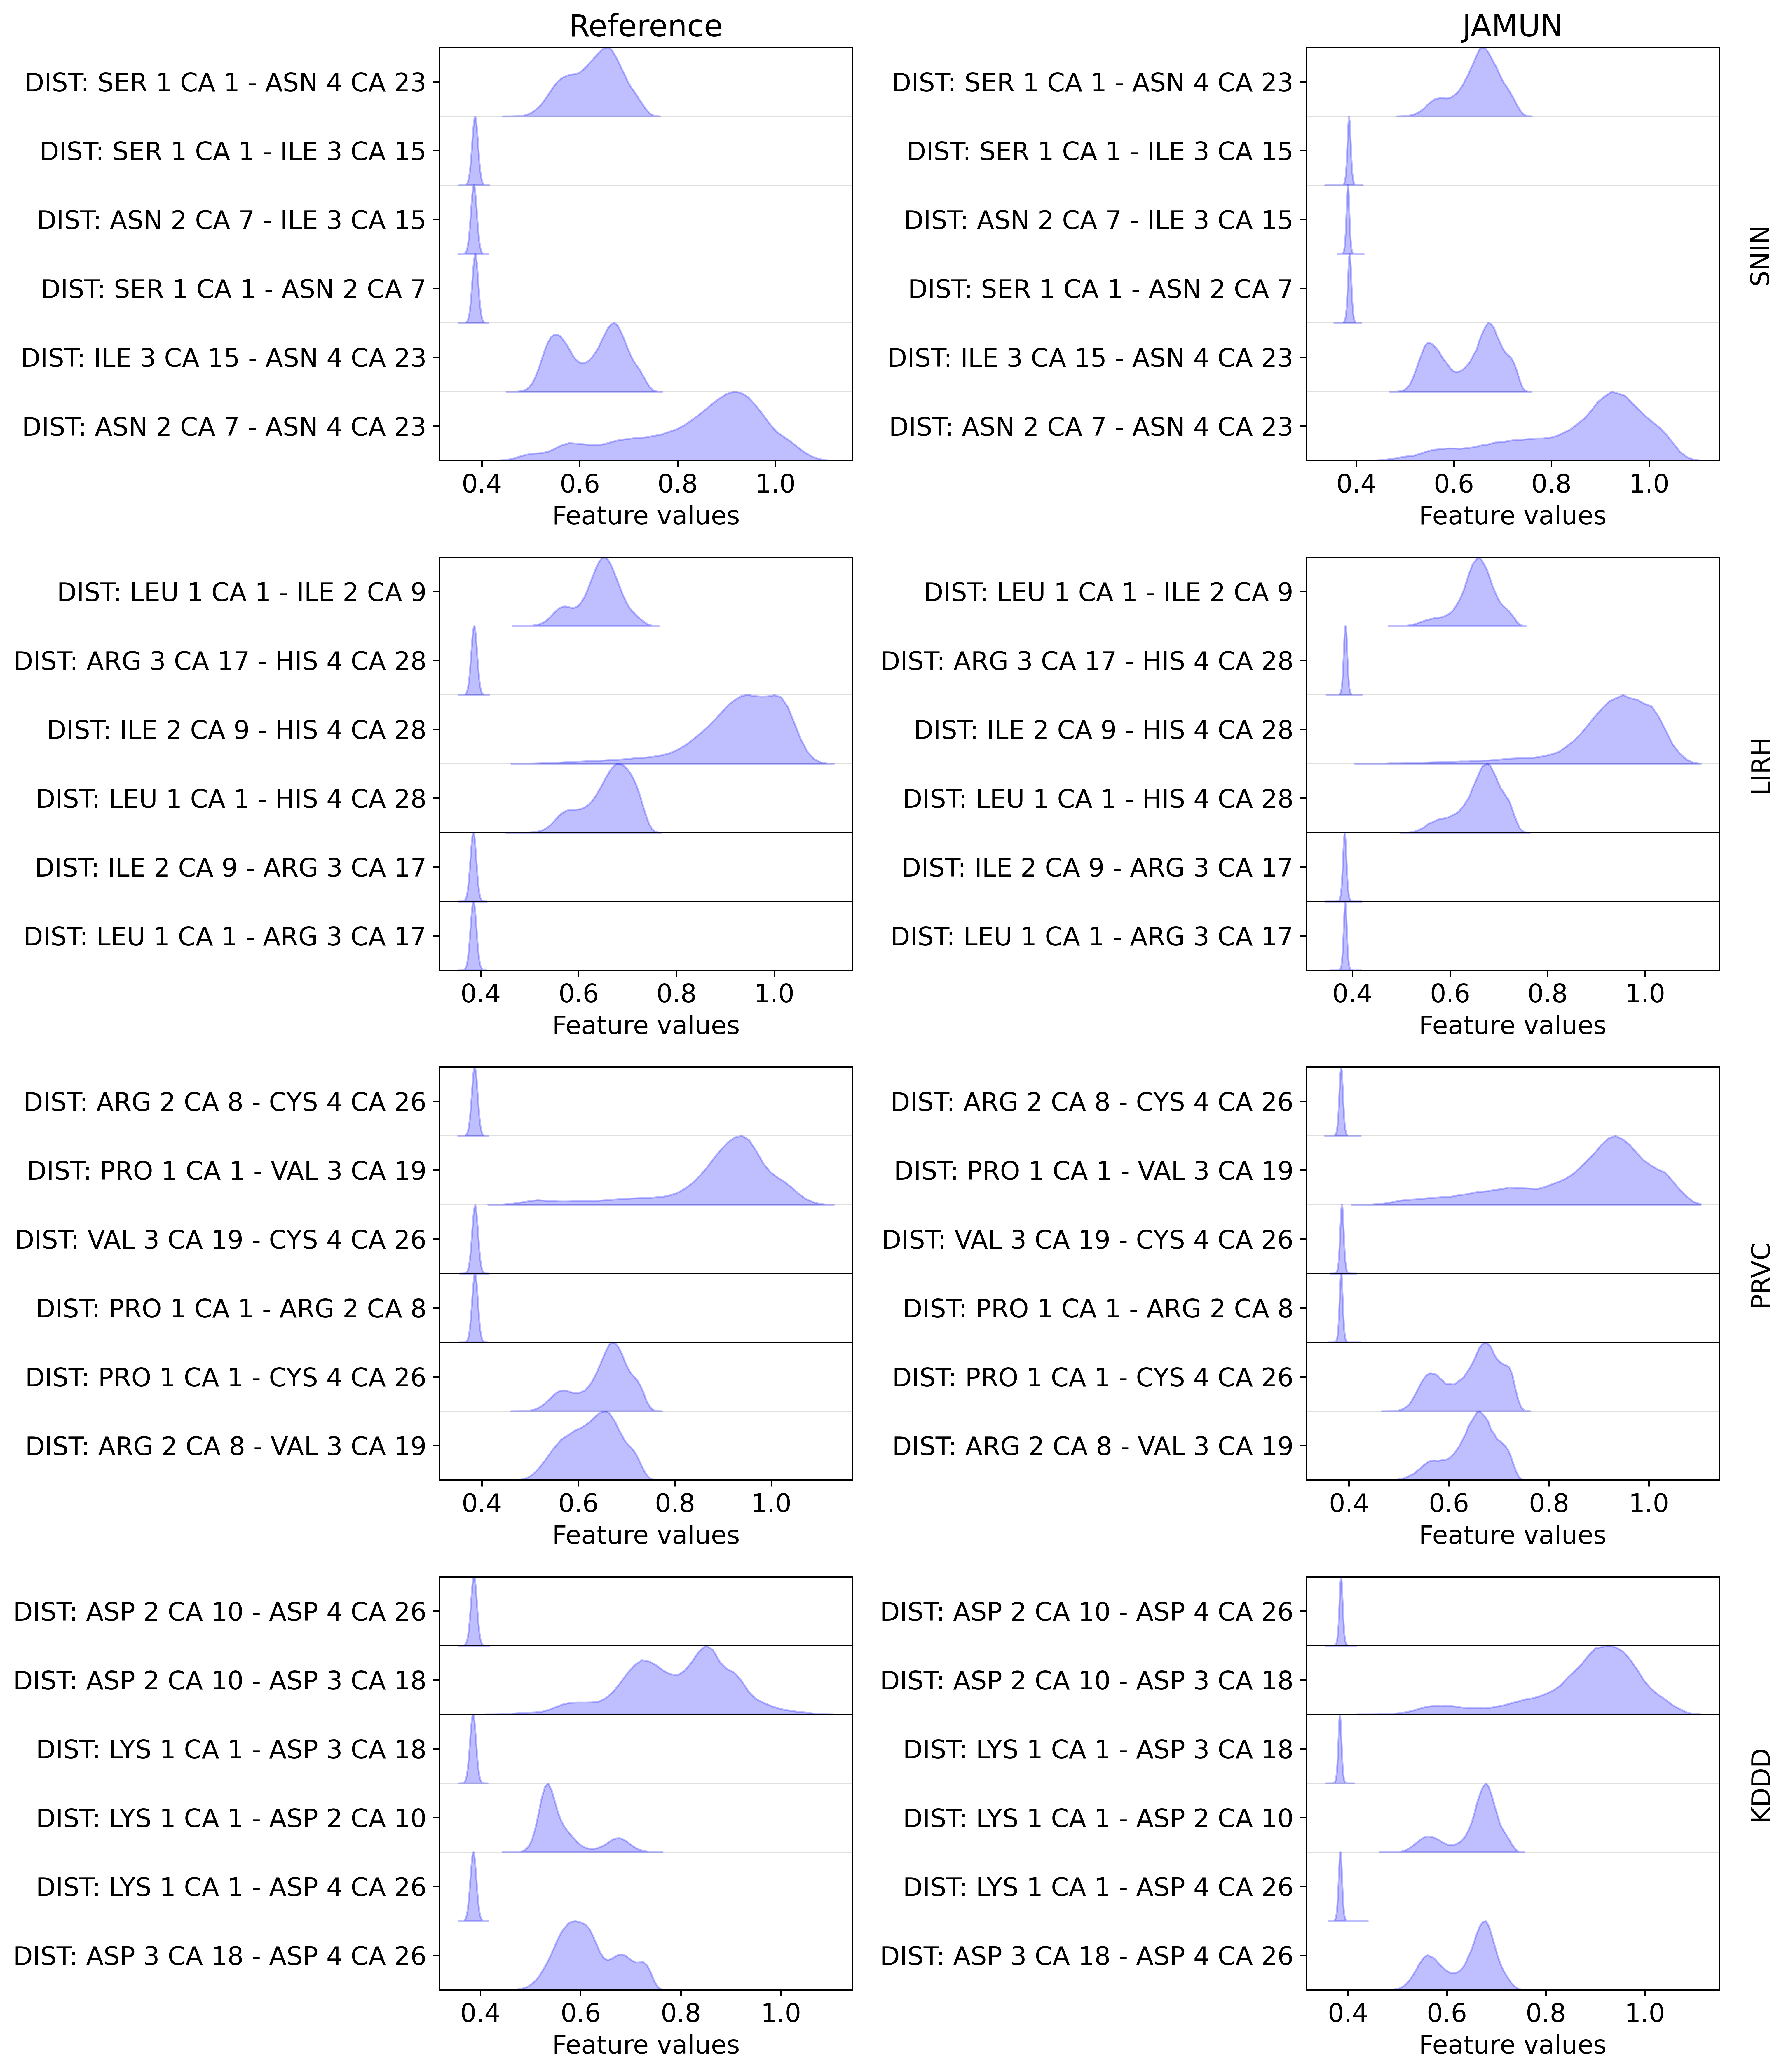

In [39]:
fig, axs = plt.subplots(nrows=len(sampled_results_df), ncols=2, figsize=(14, 4 * len(sampled_results_df)), squeeze=False)
for i, row in sampled_results_df.iterrows():
    peptide = row["peptide"]

    feats = row["results"]["featurization"]
    histograms = row["results"]["feature_histograms"]

    num_hists = len(histograms["ref_traj"]["distances"]["histograms"])
    indices = np.random.choice(num_hists, replace=False, size=min(num_hists, 10))

    pyemma_helper.plot_feature_histograms(
        histograms["ref_traj"]["distances"]["histograms"][indices],
        histograms["ref_traj"]["distances"]["edges"][indices],
        feature_labels=[feats["ref_traj"]["feats"]["distances"].describe()[i] for i in indices],
        ax=axs[i, 0]
    )

    pyemma_helper.plot_feature_histograms(
        histograms["traj"]["distances"]["histograms"][indices],
        histograms["traj"]["distances"]["edges"][indices],    
        feature_labels=[feats["traj"]["feats"]["distances"].describe()[i] for i in indices],
        ax=axs[i, 1]
    )

    axs[i, -1].text(
        1.1,
        0.5,
        format_for_plot(peptide),
        rotation=90,
        verticalalignment="center",
        horizontalalignment="center",
        transform=axs[i, -1].transAxes,
    )

axs[0, 0].set_title("Reference")
axs[0, 1].set_title("JAMUN")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "distance_histograms.pdf"), dpi=300)
plt.show()

### Jenson-Shannon Divergences (JSD)

In [43]:
JSD_torsions = collections.defaultdict(list)
for i, row in results_df.iterrows():
    peptide = row["peptide"]
    for feat in ["backbone_torsions", "sidechain_torsions", "all_torsions"]:
        if "JSD_torsion_stats" in row["results"]:
            key = "JSD_torsion_stats"
        else:
            key = "JSD_stats"
        JSD_torsions[feat].append(row["results"][key][feat])

for feat in JSD_torsions:
    print(f"Mean JSD {feat}:", np.mean(JSD_torsions[feat]))

# Save as a text file.
with open(os.path.join(output_dir, "JSDs.txt"), "w") as f:
    for feat in JSD_torsions:
        f.write(f"Mean JSD {feat}: {np.mean(JSD_torsions[feat])}\n")


Mean JSD backbone_torsions: 0.15945515677035355
Mean JSD sidechain_torsions: 0.209804040401041
Mean JSD all_torsions: 0.18716748790132068


In [44]:
JSD_tica_0 = []
JSD_tica_01 = []

for i, row in results_df.iterrows():    
    results = row["results"]["TICA_stats"]    
    JSD_tica_0.append(results["TICA-0 JSD"])
    JSD_tica_01.append(results["TICA-0,1 JSD"])


JSD_tica_0 = np.array(JSD_tica_0)
JSD_tica_01 = np.array(JSD_tica_01)

print("Mean JSD TICA-0:", np.mean(JSD_tica_0))
print("Mean JSD TICA-0,1:", np.mean(JSD_tica_01))

# Save as a text file.
with open(os.path.join(output_dir, "JSDs.txt"), "a") as f:
    f.write(f"Mean JSD TICA-0: {np.mean(JSD_tica_0)}\n")
    f.write(f"Mean JSD TICA-0,1: {np.mean(JSD_tica_01)}\n")


Mean JSD TICA-0: 0.2566880586428945
Mean JSD TICA-0,1: 0.35293297349776254


In [45]:
JSD_msms = []
for i, row in results_df.iterrows():    
    results = row["results"]["MSM_stats"]    
    JSD_msms.append(results["JSD_metastable_probs"])

JSD_msms = np.array(JSD_msms)
print("Mean JSD MSM:", np.mean(JSD_msms))

# Save as a text file.
with open(os.path.join(output_dir, "JSDs.txt"), "a") as f:
    f.write(f"Mean JSD MSM: {np.mean(JSD_msms)}\n")

Mean JSD MSM: 0.2602009238164706


In [ ]:
plt.hist(JSD_msms)
plt.title("Jenson-Shannon Distances of Metastable State Probabilities")
plt.xlabel("JSD")
plt.ylabel("Frequency")
plt.ticklabel_format(useOffset=False, style="plain")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "jsd_metastable_probs.pdf"), dpi=300)
plt.show()

### TICA Analysis

In [ ]:
fig, axs = plt.subplots(nrows=len(sampled_results_df), ncols=2, figsize=(12, 3.5 * len(sampled_results_df)), squeeze=False)
plt.rcParams.update({'font.size': 14})
for i, row in sampled_results_df.iterrows():
    peptide = row["peptide"]
    results = row["results"]["TICA_stats"]["TICA-0,1 histograms"]

    # Plot free energy.
    ref_traj_tica = results["ref_traj"]
    pyemma_helper.plot_free_energy(*ref_traj_tica, cmap="plasma", ax=axs[i, 0])
    
    axs[i, 0].ticklabel_format(useOffset=False, style="plain")

    traj_tica = results["traj"]
    pyemma_helper.plot_free_energy(*traj_tica, cmap="plasma", ax=axs[i, 1])
    if i==0:
        axs[i, 1].set_title("JAMUN")
        axs[i, 0].set_title("Reference")
    axs[i, 1].ticklabel_format(useOffset=False, style="plain")

    # Set the same limits for both plots.
    axs[i, 1].set_xlim(axs[i, 0].get_xlim())
    axs[i, 1].set_ylim(axs[i, 0].get_ylim())
    axs[i, -1].text(
        1.4,
        0.5,
        format_for_plot(peptide),
        rotation=90,
        verticalalignment="center",
        horizontalalignment="center",
        transform=axs[i, -1].transAxes,
    )

plt.suptitle("TICA-0,1 Projections", fontsize="x-large")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "tica_projections.pdf"), dpi=300)
plt.show()

In [46]:
fig, axs = plt.subplots(nrows=1, ncols=len(sampled_results_df), figsize=(8 * len(sampled_results_df), 8), squeeze=False)
plt.rcParams.update({'font.size': 12})
for i, row in sampled_results_df.iterrows():
    peptide = row["peptide"]
    results = row["results"]["autocorrelation_stats"]

    ref_autocorr = results["ref_autocorr"]
    traj_autocorr = results["traj_autocorr"]
    axs[0, i].plot(ref_autocorr, label="Reference")
    axs[0, i].plot(traj_autocorr, label="JAMUN")
    axs[0, i].set_xlabel("Lag")
    axs[0, i].set_ylabel("Autocorrelation")
    axs[0, i].text(
        0.5,
        1.04,
        format_for_plot(peptide),
        rotation=0,
        verticalalignment="center",
        horizontalalignment="center",
        transform=axs[0, i].transAxes,
        fontsize=20,
    )

# Place legend outside plot.
plt.suptitle(f"TICA-0 Autocorrelation", fontsize=32)
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.ticklabel_format(useOffset=False)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "tica_autocorrelation.pdf"), dpi=300)
plt.show()

### JSD Against Time

In [16]:
def load_JSDs_for_traj(traj_results, quantity: str = "backbone_torsions"):
    """Loads the JSDs from the results."""
    try:
        traj_results = {key: result[quantity] for key, result in traj_results.items()}
    except (IndexError, KeyError):
        pass

    traj_steps = np.array(list(traj_results.keys()))
    traj_JSDs = np.array(list(traj_results.values()))
    traj_progress = traj_steps / np.max(traj_steps)
    return {
        "steps": traj_steps,
        "JSDs": traj_JSDs,
        "progress": traj_progress,
    }

In [ ]:
if have_benchmark_reference:
    fig, axs = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=(12, 6))
    plt.rcParams.update({'font.size': 14})
    for i, row in sampled_results_df.iterrows():    

        if "JSD_torsion_stats_against_time" in row["results"]:
            key = "JSD_torsion_stats_against_time"
        else:
            key = "JSD_stats_against_time"

        results = row["results"][key]
        jsd_results = {}
        for key in ["ref_traj", "traj", "ref_benchmark_traj"]:
            jsd_results[key] = load_JSDs_for_traj(results[key])

        if i == len(sampled_results_df) - 1:
            ref_label = "Reference"
            ref_benchmark_label = "Reference (Benchmark)"
            traj_label = "JAMUN"
        else:
            ref_label = None
            ref_benchmark_label = None
            traj_label = None

        axs[0].plot(jsd_results["ref_benchmark_traj"]["progress"], jsd_results["ref_benchmark_traj"]["JSDs"], color="C0", label=ref_label)
        axs[0].plot(jsd_results["traj"]["progress"], jsd_results["traj"]["JSDs"], color="C1", label=traj_label)
        axs[1].plot(jsd_results["ref_traj"]["progress"], jsd_results["ref_traj"]["JSDs"], color="C0", label=ref_benchmark_label)
        axs[1].plot(jsd_results["traj"]["progress"], jsd_results["traj"]["JSDs"], color="C1", label=traj_label)

    fig.suptitle("JSD on Backbone Torsions")
    axs[0].set_xlabel("Fraction of Trajectory Progress for JAMUN", fontsize=14)
    axs[0].set_xscale("log")
    axs[0].set_ylabel("Jenson-Shannon Distance", fontsize=14)
    axs[0].legend(fontsize=14)
    axs[1].set_xlabel("Fraction of Trajectory Progress for Reference", fontsize=14)
    axs[1].set_xscale("log")
    axs[1].legend(fontsize=14)
    axs[1].set_yticks([])

    plt.subplots_adjust(hspace=0.06, wspace=0.04)
    plt.savefig(os.path.join(output_dir, "jsd_against_time.pdf"), dpi=300)
    plt.show()

else:
    fig, ax = plt.subplots(ncols=1, sharey=True, sharex=True, figsize=(12, 6), squeeze=True)
    plt.rcParams.update({'font.size': 14})
    for i, row in sampled_results_df.iterrows():    

        if "JSD_torsion_stats_against_time" in row["results"]:
            key = "JSD_torsion_stats_against_time"
        else:
            key = "JSD_stats_against_time"

        results = row["results"][key]
        jsd_results = {}
        for key in ["ref_traj", "traj"]:
            jsd_results[key] = load_JSDs_for_traj(results[key])

        if i == len(sampled_results_df) - 1:
            ref_label = "Reference"
            traj_label = "JAMUN"
        else:
            ref_label = None
            traj_label = None

        ax.plot(jsd_results["ref_traj"]["progress"], jsd_results["ref_traj"]["JSDs"], color="C0", label=ref_label)
        ax.plot(jsd_results["traj"]["progress"], jsd_results["traj"]["JSDs"], color="C1", label=traj_label)

    fig.suptitle("JSD on Backbone Torsions")
    ax.set_xlabel("Fraction of Trajectory Progress for Reference", fontsize=14)
    ax.set_xscale("log")
    ax.legend(fontsize=14)
    # ax.set_yticks([])

    plt.subplots_adjust(hspace=0.06, wspace=0.04)
    plt.savefig(os.path.join(output_dir, "jsd_against_time.pdf"), dpi=300)
    plt.show()

### MSM State Probabilities

In [ ]:
all_ref_metastable_probs = []
all_traj_metastable_probs = []
plt.rcParams.update({'font.size': 12})
for i, row in results_df.iterrows():    
    results = row["results"]["MSM_stats"]
    ref_metastable_probs = results["ref_metastable_probs"]
    traj_metastable_probs = results["traj_metastable_probs"]
    
    all_ref_metastable_probs.append(ref_metastable_probs)
    all_traj_metastable_probs.append(traj_metastable_probs)

all_ref_metastable_probs = np.concatenate(all_ref_metastable_probs)
all_traj_metastable_probs = np.concatenate(all_traj_metastable_probs)

# Scatter plot of probabilities.
plt.scatter(all_ref_metastable_probs, all_traj_metastable_probs, alpha=0.3, edgecolors="none")

# Fit line.
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
    all_ref_metastable_probs, all_traj_metastable_probs
)

# Create x points for line.
x_line = np.array([-0.5, 1.5])
y_line = slope * x_line + intercept

# Plot the fitted line with dashed style.
plt.plot(x_line, y_line, color='red', linestyle='--')
plt.text(0.45, 0.90, f'R² = {r_value**2:.3f}', transform=plt.gca().transAxes, color='red')

plt.title("Metastable State Probabilities")
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.xlabel("Reference")
plt.ylabel("JAMUN")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "metastable_probs.pdf"), dpi=300)
plt.show()

### JSD MSM Against Time

In [ ]:
if have_benchmark_reference:
    for i, row in sampled_results_df.iterrows():    

        if "JSD_MSM_stats_against_time" not in row["results"]:
            continue

        results = row["results"]["JSD_MSM_stats_against_time"]
        jsd_results = {}
        for key in ["ref_traj", "traj", "ref_benchmark_traj"]:
            jsd_results[key] = load_JSDs_for_traj(results[key])
        
        if i == len(sampled_results_df) - 1:
            ref_label = "Reference"
            ref_benchmark_label = "Reference (Benchmark)"
            traj_label = "JAMUN"
        else:
            ref_label = None
            ref_benchmark_label = None
            traj_label = None

        axs[0].plot(jsd_results["ref_benchmark_traj"]["progress"], jsd_results["ref_benchmark_traj"]["JSDs"], color="C0", label=ref_label)
        axs[0].plot(jsd_results["traj"]["progress"], jsd_results["traj"]["JSDs"], color="C1", label=traj_label)
        axs[1].plot(jsd_results["ref_traj"]["progress"], jsd_results["ref_traj"]["JSDs"], color="C0", label=ref_benchmark_label)
        axs[1].plot(jsd_results["traj"]["progress"], jsd_results["traj"]["JSDs"], color="C1", label=traj_label)

    fig.suptitle("JSD on Metastable State Probabilities")
    axs[0].set_xlabel("Fraction of Trajectory Progress for JAMUN", fontsize=14)
    axs[0].set_xscale("log")
    axs[0].set_ylabel("Jenson-Shannon Distance", fontsize=14)
    axs[0].legend(fontsize=14)
    axs[1].set_xlabel("Fraction of Trajectory Progress for Reference", fontsize=14)
    axs[1].set_xscale("log")
    axs[1].legend(fontsize=14)
    axs[1].set_yticks([])
    plt.subplots_adjust(hspace=0.06, wspace=0.04)
    plt.ticklabel_format(useOffset=False, style="plain")
    plt.savefig(os.path.join(output_dir, "jsd_msm_against_time.pdf"), dpi=300)
    plt.show()

else:

    fig, axs = plt.subplots(ncols=1, sharey=True, sharex=True, figsize=(12, 6), squeeze=False)
    plt.rcParams.update({'font.size': 14})
    for i, row in sampled_results_df.iterrows():    

        if "JSD_MSM_stats_against_time" not in row["results"]:
            continue

        results = row["results"]["JSD_MSM_stats_against_time"]
        jsd_results = {}
        for key in ["ref_traj", "traj"]:
            jsd_results[key] = load_JSDs_for_traj(results[key])

        if i == len(sampled_results_df) - 1:
            ref_label = "Reference"
            traj_label = "JAMUN"
        else:
            ref_label = None
            traj_label = None

        axs[0][0].plot(jsd_results["ref_traj"]["progress"], jsd_results["ref_traj"]["JSDs"], color="C0", label=ref_label)
        axs[0][0].plot(jsd_results["traj"]["progress"], jsd_results["traj"]["JSDs"], color="C1", label=traj_label)

    fig.suptitle("JSD on Metastable State Probabilities")
    axs[0][0].set_xlabel("Fraction of Trajectory Progress for Reference", fontsize=14)
    axs[0][0].set_xscale("log")
    axs[0][0].legend(fontsize=14)
    axs[0][0].set_yticks([])

    plt.subplots_adjust(hspace=0.06, wspace=0.04)
    plt.savefig(os.path.join(output_dir, "jsd_msm_against_time.pdf"), dpi=300)
    plt.show()